In [43]:
import re
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

In [ ]:
current_dir = os.getcwd()
print(f"Current directory: {current_dir}")

In [31]:
def parse_timings_from_file(filename):
    """Extract timing values from one file."""
    timings = []
    with open(filename, "r") as f:
        for line in f:
            # match lines like "time total: 135.405116"
            match = re.search(r"time .*?:\s+([\d\.Ee+-]+)", line)
            if match:
                timings.append(float(match.group(1)))
    return timings


def collect_data():
    # find files named like output${threads}P${P}
    files = glob.glob("output*P*")

    threads_list = []
    all_timings = []

    for fname in files:
        # extract thread number from filename (between "output" and "P")
        match = re.search(r"outputT(\d+)P", fname)
        if not match:
            continue
        threads = int(match.group(1))

        timings = parse_timings_from_file(fname)

        threads_list.append(threads)
        all_timings.append(timings)

    array_T = np.array(threads_list)
    array_time = np.array(all_timings)

    return array_T, array_time



array_T, array_time = collect_data()
array_T

array([ 2,  4, 32,  1, 16,  8, 64])

In [32]:
idx = np.argsort(array_T)
array_T[idx]

array([ 1,  2,  4,  8, 16, 32, 64])

In [42]:
array_time[idx]

array([[1.35405116e+02, 1.20000000e-04, 1.34419565e+02, 4.00000000e-05,
        9.48052000e-01, 3.90000000e-05, 2.77400000e-02, 9.75871000e-01],
       [8.20180520e+01, 1.05000000e-04, 8.14710010e+01, 4.70000000e-05,
        5.21942000e-01, 3.60000000e-05, 1.81170000e-02, 5.40143000e-01],
       [7.23165110e+01, 1.19000000e-04, 7.19744590e+01, 7.00000000e-05,
        3.16827000e-01, 3.90000000e-05, 1.92140000e-02, 3.36150000e-01],
       [7.26509450e+01, 1.19000000e-04, 7.23778780e+01, 4.60000000e-05,
        2.40545000e-01, 3.70000000e-05, 2.51710000e-02, 2.65799000e-01],
       [6.45147300e+01, 1.56000000e-04, 6.42721560e+01, 6.40000000e-05,
        2.04307000e-01, 3.60000000e-05, 2.93150000e-02, 2.33722000e-01],
       [3.24247720e+01, 1.50000000e-04, 3.22658980e+01, 3.70000000e-05,
        1.06638000e-01, 3.60000000e-05, 4.03160000e-02, 1.47027000e-01],
       [1.64955630e+01, 1.53000000e-04, 1.63675250e+01, 3.60000000e-05,
        6.67450000e-02, 3.60000000e-05, 4.08080000e-02, 1.

In [57]:
from matplotlib.ticker import ScalarFormatter

In [63]:
for e in plt.style.available:
    print(e)

Solarize_Light2
_classic_test_patch
_mpl-gallery
_mpl-gallery-nogrid
bmh
classic
dark_background
fast
fivethirtyeight
ggplot
grayscale
petroff10
seaborn-v0_8
seaborn-v0_8-bright
seaborn-v0_8-colorblind
seaborn-v0_8-dark
seaborn-v0_8-dark-palette
seaborn-v0_8-darkgrid
seaborn-v0_8-deep
seaborn-v0_8-muted
seaborn-v0_8-notebook
seaborn-v0_8-paper
seaborn-v0_8-pastel
seaborn-v0_8-poster
seaborn-v0_8-talk
seaborn-v0_8-ticks
seaborn-v0_8-white
seaborn-v0_8-whitegrid
tableau-colorblind10


In [ ]:
plt.style.use('default') 
# Set the ultra-minimal style
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.linewidth': 0.5,

    # remove borders
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.bottom': False,

    # ticks
    'xtick.color': 'lightgray',
    'ytick.color': 'lightgray',
    'xtick.direction': 'out',
    'ytick.direction': 'out',

    # grid
    'axes.grid': True,          # enable grid globally
    'grid.color': '#eaeaea',  # very light gray
    'grid.linestyle': '-',
    'grid.linewidth': 0.5,
    'grid.alpha': 1.0,

    # lines
    'lines.linewidth': 1.0,

    # font
    'font.size': 10,
    'font.family': 'sans-serif',
    'text.color': 'gray',   # axis labels, titles, etc.
    'axes.labelcolor': 'gray',
})


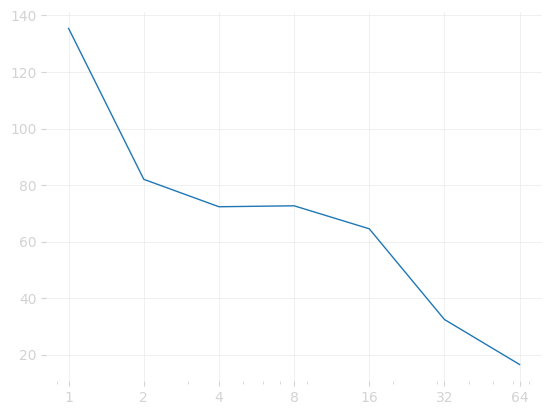

In [94]:
fig, ax = plt.subplots()

ax.plot(array_T[idx], array_time[idx][:, 0])
ax.set_xscale("log")
ax.set_xticks(array_T[idx])
ax.get_xaxis().set_major_formatter(ScalarFormatter())

plt.show()